In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from os import listdir
from os.path import isfile, join
import cv2
import imageio
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
imagesDir = 'katkam-scaled'
weatherDataDir = 'yvr-weather'
   #https://stackoverflow.com/questions/33369832/read-multiple-images-on-a-folder-in-opencv-python
onlyfiles = [ f for f in listdir(imagesDir) if isfile(join(imagesDir,f)) ]

In [3]:
images = np.empty(len(onlyfiles), dtype=object)

for n in range(0, len(onlyfiles)):
      images[n] = cv2.imread( join(imagesDir,onlyfiles[n]) )

In [4]:
weatherDataFiles = [ f for f in listdir(weatherDataDir) if isfile(join(weatherDataDir,f)) ]

In [5]:
weatherData = pd.read_csv(join(weatherDataDir, weatherDataFiles[0]), usecols=[1, 2, 3, 4, 6, 24], skiprows=np.linspace(0, 15))

In [6]:
for n in range(1, len(weatherDataFiles)):
    weatherData = weatherData.append(pd.read_csv(join(weatherDataDir, weatherDataFiles[n]), usecols=[1, 2, 3, 4, 6, 24], skiprows=np.linspace(0, 15)))
    

In [7]:
weatherDataCleaned = weatherData.dropna().reset_index(drop=True)

In [8]:
weatherDataCleaned['ID'] = weatherDataCleaned['Year']*1e6 + weatherDataCleaned['Month']*1e4 + weatherDataCleaned['Day']*1e2 + weatherDataCleaned['Time'].str.slice(0, 2).astype(float)
weatherDataCleaned['ID'] = weatherDataCleaned['ID'].astype(int)

In [9]:
actualImages = np.empty([weatherDataCleaned.shape[0], 192, 256, 3], dtype=np.uint8)

In [10]:
numImages = 0
imageIdx = np.full(weatherDataCleaned.shape[0], -1)
for n in range(0, weatherDataCleaned.shape[0]):
    filename = "katkam-" + str(weatherDataCleaned['ID'][n]) + "0000" + ".jpg"
    if (filename in onlyfiles):
        actualImages[numImages, :, :, :] = imageio.imread(join(imagesDir, filename))
        imageIdx[n] = numImages
        numImages = numImages+1

In [11]:
weatherDataCleaned['hasImage'] = imageIdx

In [13]:
weatherDataCleaned = weatherDataCleaned[weatherDataCleaned['hasImage'] >= 0]
actualImages = actualImages[ 0:numImages, :, :, :]

In [14]:
greyImages = np.uint8((actualImages[:, :, :, 0].astype(np.float) + actualImages[:, :, :, 1].astype(np.float) + actualImages[:, :, :, 2].astype(np.float))/3)

In [15]:
#unravelled = greyImages.reshape(np.shape(greyImages)[0], np.shape(greyImages)[1]*np.shape(greyImages)[2])
#unravelled[100, 0:2560:256]
#images_train, images_test, names_train, names_test = train_test_split(unravelled, weatherDataCleaned['Weather'].values)
#myModel = make_pipeline(
    #PCA(200),
    #SVC(C=1))
#myModel.fit(images_train, names_train)
#myModel.score(images_test, names_test)

In [16]:
skies = actualImages[:, 0:100, :, :]

In [17]:
blueness = (skies[:, :, :, 2].sum(axis=(1, 2)))/(skies[:, :, :, :].sum(axis=(1, 2, 3)))

In [18]:
redness = (skies[:, :, :, 0].sum(axis=(1, 2)))/(skies[:, :, :, :].sum(axis=(1, 2, 3)))
greeness = (skies[:, :, :, 1].sum(axis=(1, 2)))/(skies[:, :, :, :].sum(axis=(1, 2, 3)))

In [19]:
lightlevel = (skies[:, :, :, :].sum(axis=(1, 2, 3)))

In [20]:
weatherDataCleaned['Blueness'] = blueness

C:\Users\adria\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [21]:
weatherDataCleaned['Greeness'] = greeness
weatherDataCleaned['Redness'] = redness

C:\Users\adria\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\adria\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [22]:
weatherDataCleaned['Brightness'] = lightlevel

C:\Users\adria\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


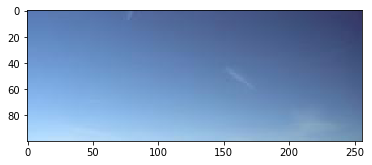

In [23]:
# Find blueness of sky
# Cutoff sky part
plt.imshow(skies[0, :, :])
plt.show()

In [24]:
lightlevel

array([10898682, 12242949, 14474643, ..., 15233917, 15117650, 11938390], dtype=uint32)

In [25]:
# Get the gradients of each image
gradients = np.zeros(np.shape(greyImages), dtype=np.int16)
for n in range(0, np.shape(greyImages)[0]):
    gradients[n, :, :] = np.absolute(cv2.Laplacian(greyImages[n, :, :], ddepth=cv2.CV_16S))
    
    
grad = (gradients[:, 0:100, :].sum(axis=(1, 2)))

In [26]:
weatherDataCleaned['Gradient'] = grad

C:\Users\adria\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [27]:
weatherDataReady = weatherDataCleaned[weatherDataCleaned['Brightness'] > 6000000]

In [28]:
#parameters = weatherDataReady[['Blueness', 'Brightness', 'Gradient']].values
parameters = weatherDataReady[['Blueness', 'Redness', 'Greeness', 'Brightness', 'Gradient']].values

In [29]:
weatherDataReady['Weather'].unique()

array(['Mainly Clear', 'Mostly Cloudy', 'Cloudy', 'Rain Showers',
       'Moderate Rain Showers', 'Clear', 'Rain', 'Rain,Fog', 'Drizzle',
       'Rain Showers,Fog', 'Thunderstorms', 'Fog', 'Drizzle,Fog',
       'Moderate Rain Showers,Fog', 'Rain,Drizzle', 'Moderate Rain',
       'Moderate Rain,Drizzle', 'Moderate Rain,Fog', 'Rain,Drizzle,Fog',
       'Heavy Rain,Fog', 'Snow', 'Snow,Fog', 'Rain,Snow', 'Freezing Fog',
       'Rain,Snow,Fog', 'Moderate Snow', 'Snow Showers',
       'Rain Showers,Snow Showers,Fog', 'Rain Showers,Snow Pellets',
       'Rain Showers,Snow Showers',
       'Heavy Rain Showers,Moderate Snow Pellets,Fog',
       'Heavy Rain,Moderate Hail,Fog'], dtype=object)

In [30]:
groupPrecipitating = ('Drizzle', 'Drizzle, Fog', 'Heavy Rain Showers,Moderate Snow Pellets,Fog', 'Heavy Rain,Fog', 
                'Heavy Rain,Moderate Hail,Fog', 'Moderate Rain', 'Moderate Rain Showers', 'Moderate Rain Showers,Fog',
                'Moderate Rain,Drizzle', 'Moderate Rain,Fog', 'Rain', 'Rain Showers', 'Rain Showers,Fog', 
                'Rain Showers,Snow Pellets', 'Rain Showers,Snow Showers', 'Rain Showers,Snow Showers,Fog', 
                'Rain,Drizzle', 'Rain,Drizzle,Fog', 'Rain,Fog', 'Rain,Snow,Fog', 'Thunderstorms', 'Drizzle,Fog', 
                'Snow', 'Snow Showers', 'Snow,Fog', 'Snowing', 'Rain,Snow', 'Moderate Snow')
groupCloudy = ('Mostly Cloudy', 'Cloudy', 'Fog', 'Freezing Fog')
#groupClear = ('Mainly Clear', 'Clear')

In [31]:
weatherDataGrouped = weatherDataReady

In [114]:
weatherDataGrouped.loc[weatherDataGrouped['Weather'].isin(groupPrecipitating), 'Weather'] = 'Precipitating'
weatherDataGrouped.loc[weatherDataGrouped['Weather'].isin(groupCloudy), 'Weather'] = 'Cloudy'
#weatherDataGrouped.loc[weatherDataGrouped['Weather'].isin(groupClear), 'Weather'] = 'Clear'

C:\Users\adria\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [126]:
weatherDataGrouped['Weather'][weatherDataGrouped['Weather'].isin(['Precipitating'])] = 'Precipitating'

C:\Users\adria\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\adria\Anaconda3\lib\site-packages\pandas\core\generic.py:5088: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\Users\adria\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2881: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [33]:
images_train, images_test, names_train, names_test = train_test_split(weatherDataGrouped[['Blueness', 'Redness', 'Greeness', 'Brightness', 'Gradient']].values, weatherDataGrouped[['Weather']].values)
myModel = make_pipeline(
    StandardScaler(),
    SVC(C=2, class_weight='balanced'))
myModel.fit(images_train, names_train)
myModel.score(images_test, names_test)

C:\Users\adria\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.56868537666174301

In [113]:
np.shape(np.ravel(weatherDataGrouped[['Weather']].values))

(2707,)

In [110]:
a = weatherDataGrouped.groupby('Weather')
b = a.agg('count')
c = [b.iloc[0][0], b.iloc[1][0], b.iloc[2][0], b.iloc[3][0]]/b.sum()[0]

In [111]:
c

array([ 0.09087551,  0.41337274,  0.18359808,  0.31215368])

In [34]:
weatherDataGrouped['Weather'].unique()

array(['Mainly Clear', 'Cloudy', 'Precipitating', 'Clear'], dtype=object)

In [35]:
myModel.predict(weatherDataGrouped[['Blueness', 'Redness', 'Greeness', 'Brightness', 'Gradient']].values) == weatherDataGrouped[['Weather']].values

array([[ True,  True,  True, ..., False, False, False],
       [False, False, False, ...,  True,  True, False],
       [False, False, False, ...,  True,  True, False],
       ..., 
       [False, False, False, ...,  True,  True, False],
       [False, False, False, ...,  True,  True, False],
       [ True,  True,  True, ..., False, False, False]], dtype=bool)

In [36]:
n = 0

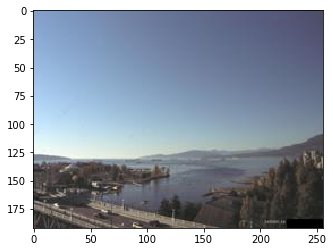

Actual weather is Clear

Predicted weather is Clear



In [37]:
n = 2692
plt.imshow(actualImages[2929, :, :, :])
plt.show()
print("Actual weather is " + weatherDataGrouped[['Weather']].values[n][0] + "\n")
print("Predicted weather is " + myModel.predict(weatherDataGrouped[['Blueness', 'Redness', 'Greeness', 'Brightness', 'Gradient']].values)[n] + "\n")

In [38]:
wrongCounter = pd.DataFrame(weatherDataGrouped[['Weather']])

In [39]:
myModel.predict(weatherDataGrouped[['Blueness', 'Redness', 'Greeness', 'Brightness', 'Gradient']].values)[0]

'Mainly Clear'

In [40]:
np.shape(np.reshape(weatherDataGrouped[['Weather']].values, -1) == myModel.predict(weatherDataGrouped[['Blueness', 'Redness', 'Greeness', 'Brightness', 'Gradient']]))

(2707,)

In [41]:
weatherDataWrong = weatherDataGrouped[np.reshape(weatherDataGrouped[['Weather']].values, -1) != myModel.predict(weatherDataGrouped[['Blueness', 'Redness', 'Greeness', 'Brightness', 'Gradient']])]

In [42]:
wrongCategories = weatherDataWrong.groupby('Weather')

In [43]:
wrongCategories['ID'].agg('count')

Weather
Clear             23
Cloudy           686
Mainly Clear     315
Precipitating     93
Name: ID, dtype: int64

In [44]:
wrongCounter['Guessed'] = myModel.predict(weatherDataGrouped[['Blueness', 'Redness', 'Greeness', 'Brightness', 'Gradient']].values)

In [45]:
wrongCounter = wrongCounter.reset_index()

In [46]:
wrongCounter[wrongCounter['Weather'] == 'Cloudy'].groupby('Guessed').agg('count')

,index,Weather
Guessed,,
Clear,71,71
Cloudy,433,433
Mainly Clear,161,161
Precipitating,454,454


In [47]:
wrongCounter[wrongCounter['Weather'] == 'Clear'].groupby('Guessed').agg('count')

,index,Weather
Guessed,,
Clear,223,223
Cloudy,4,4
Mainly Clear,18,18
Precipitating,1,1


In [48]:
wrongCounter[wrongCounter['Weather'] == 'Mainly Clear'].groupby('Guessed').agg('count')

,index,Weather
Guessed,,
Clear,236,236
Cloudy,67,67
Mainly Clear,182,182
Precipitating,12,12


In [49]:
wrongCounter[wrongCounter['Weather'] == 'Precipitating'].groupby('Guessed').agg('count')

,index,Weather
Guessed,,
Clear,16,16
Cloudy,64,64
Mainly Clear,13,13
Precipitating,752,752


In [50]:
weatherDataGrouped.iloc[2692]

Year                2017
Month                 10
Day                   27
Time               16:00
Temp (°C)           11.7
Weather            Clear
ID            2017102716
hasImage            2929
Blueness         0.39669
Greeness        0.324696
Redness         0.278614
Brightness      11131315
Gradient           33146
Name: 5614, dtype: object

In [66]:
plt.imshow(gradients[2129, 0:100, :], cmap='gray')

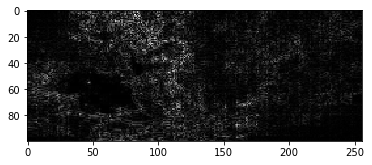

In [67]:
plt.show()

In [65]:
grad.argmax()

2129

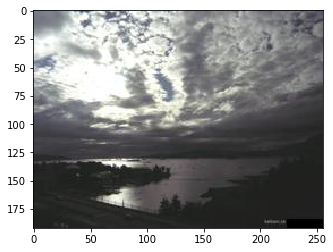

In [69]:
plt.imshow(cv2.actualImages[2129, :, :, :])
plt.show()

In [77]:
plt.imshow(cv2.Laplacian(greyImages[2129, :, :], ddepth=cv2.CV_16S), cmap='gray')

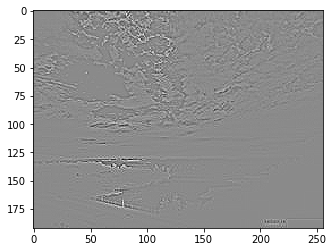

In [78]:
plt.show()